In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.12/07


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  #infile = '../test7/ntuple_SingleMuon_Endcap_2GeV_add.5.root'
  infile = '../test7/ntuple_SingleMuon_Displaced_FlatPhi_2GeV_add.5.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  #tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return tree

def load_pgun_omtf():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Overlap_3GeV_add.5.root'
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  #tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return tree

In [4]:
maxEvents = 400000
#maxEvents = 10000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

nlayers = 16  # 5 (CSC) + 4 (RPC) + 3 (GEM) + 4 (DT)

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99  # (type, station, ring) -> layer
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 1  # ME1/3
    lut[1,2,1] = 2  # ME2/1
    lut[1,2,2] = 2  # ME2/2
    lut[1,3,1] = 3  # ME3/1
    lut[1,3,2] = 3  # ME3/2
    lut[1,4,1] = 4  # ME4/1
    lut[1,4,2] = 4  # ME4/2
    lut[2,1,2] = 5  # RE1/2
    lut[2,1,3] = 5  # RE1/3
    lut[2,2,2] = 6  # RE2/2
    lut[2,2,3] = 6  # RE2/3
    lut[2,3,1] = 7  # RE3/1
    lut[2,3,2] = 7  # RE3/2
    lut[2,3,3] = 7  # RE3/3
    lut[2,4,1] = 8  # RE4/1
    lut[2,4,2] = 8  # RE4/2
    lut[2,4,3] = 8  # RE4/3
    lut[3,1,1] = 9  # GE1/1
    lut[3,2,1] = 10 # GE2/1
    lut[4,1,1] = 11 # ME0
    lut[0,1,1] = 12 # MB1
    lut[0,2,1] = 13 # MB2
    lut[0,3,1] = 14 # MB3
    lut[0,4,1] = 15 # MB4
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    return entry

find_emtf_layer = EMTFLayer()

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def calculate_d0(invPt, phi, xv, yv, B=3.811):
  _invPt = np.asarray(invPt, dtype=np.float64)   # needs double precision
  _invPt = np.where(np.abs(_invPt) < 1./10000, np.sign(_invPt+1e-15) * 1./10000, _invPt)
  _R = -1.0 / (0.003 * 3.811 * _invPt)           # R = -pT/(0.003 q B)  [cm]
  _xc = xv - (_R * np.sin(phi))                  # xc = xv - R sin(phi)
  _yc = yv + (_R * np.cos(phi))                  # yc = yv + R cos(phi)
  _d0 = _R - (np.sign(_R) * np.hypot(_xc, _yc))  # d0 = R - sign(R) * sqrt(xc^2 + yc^2)
  return _d0.astype(np.float32, casting='same_kind')

# Decide EMTF legit hit
def is_emtf_legit_hit(hit):
  def check_bx(hit):
    if hit.type == kCSC:
      return hit.bx in (-1,0)
    elif hit.type == kDT:
      return hit.bx in (-1,0)
    else:
      return hit.bx == 0
  def check_emtf_phi(hit):
    if hit.type == kME0:
      return hit.emtf_phi > 0
    elif hit.type == kDT:
      return hit.emtf_phi > 0
    else:
      return True
  #return check_bx(hit) and check_emtf_phi(hit)
  return check_emtf_phi(hit)

In [5]:
# Main analysis

def analysis(verbose=1, omtf=False):
  if omtf:
    tree = load_pgun_omtf()
  else:
    tree = load_pgun()

  out_part, out_hits = [], []

  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break

    if verbose and (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))

    # Skip events with very few hits
    if not len(evt.hits) >= 2:
      continue

    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kDT and (hit.station == 1 or hit.station == 2):
        has_ME1 = True
        break
    #if not has_ME1:
    #  continue

    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    part.d0 = calculate_d0(part.invpt, part.phi, part.vx, part.vy)

    ## Skip low pT muons
    #if part.pt < 20:
    #  continue

    def pick_the_median_unsorted(lst):
      lst = np.sort(lst)
      middle = 0 if len(lst) == 0 else (len(lst)-1)//2
      return lst[middle]

    emtf_layers = np.array([find_emtf_layer(hit) for hit in evt.hits])
    emtf_thetas = np.array([hit.emtf_theta for hit in evt.hits])
    theta_median = pick_the_median_unsorted(emtf_thetas)

    # Output
    for i in xrange(len(evt.hits)):
      out_part.append((part.invpt, part.eta, part.phi, part.d0))
      out_hits.append((emtf_layers[i], emtf_thetas[i] - theta_median))
    continue  # end loop over events

  if verbose: print "DONE"
  return np.asarray(out_part), np.asarray(out_hits)

In [6]:
# Load

outfile = 'x_theta_displ2_out.0.npz'
with np.load(outfile) as loaded:
  out_part = loaded['out_part']
  out_hits = loaded['out_hits']

print out_part.shape, out_hits.shape

(2811420, 4) (2811420, 2)


In [7]:
# Styling
plt.style.use('tdrstyle.mplstyle')

In [8]:
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [9]:
from scipy.optimize import curve_fit

def gaus(x,a,mu,sig):
  return a*np.exp(-0.5*np.square((x-mu)/sig))

def fit_gaus(hist, edges, mu=0., sig=1.):
  hist = hist.astype('float64')
  edges = edges.astype('float64')
  xdata = (edges[1:] + edges[:-1])/2
  ydata = hist
  popt, pcov = curve_fit(gaus, xdata, ydata, p0=[np.max(hist),mu,sig])
  if not np.isfinite(pcov).all():
    raise Exception('Fit has failed to converge.')
  return popt

In [10]:
convert_to_rad = lambda x: x * np.deg2rad(1./60)

part_invpt = out_part[:, 0]
part_q = np.sign(out_part[:, 0])
part_eta = out_part[:, 1]
part_phi = out_part[:, 2]
part_d0 = out_part[:, 3]

0 15.564704805412655
2 2.6731585806330056
3 2.4087791077740803
4 4.489074684924453
7 2.700004990630398
8 5.759263781172976
9 20.809871016253055
10 5.801805185882789
11 2.277529011691307


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


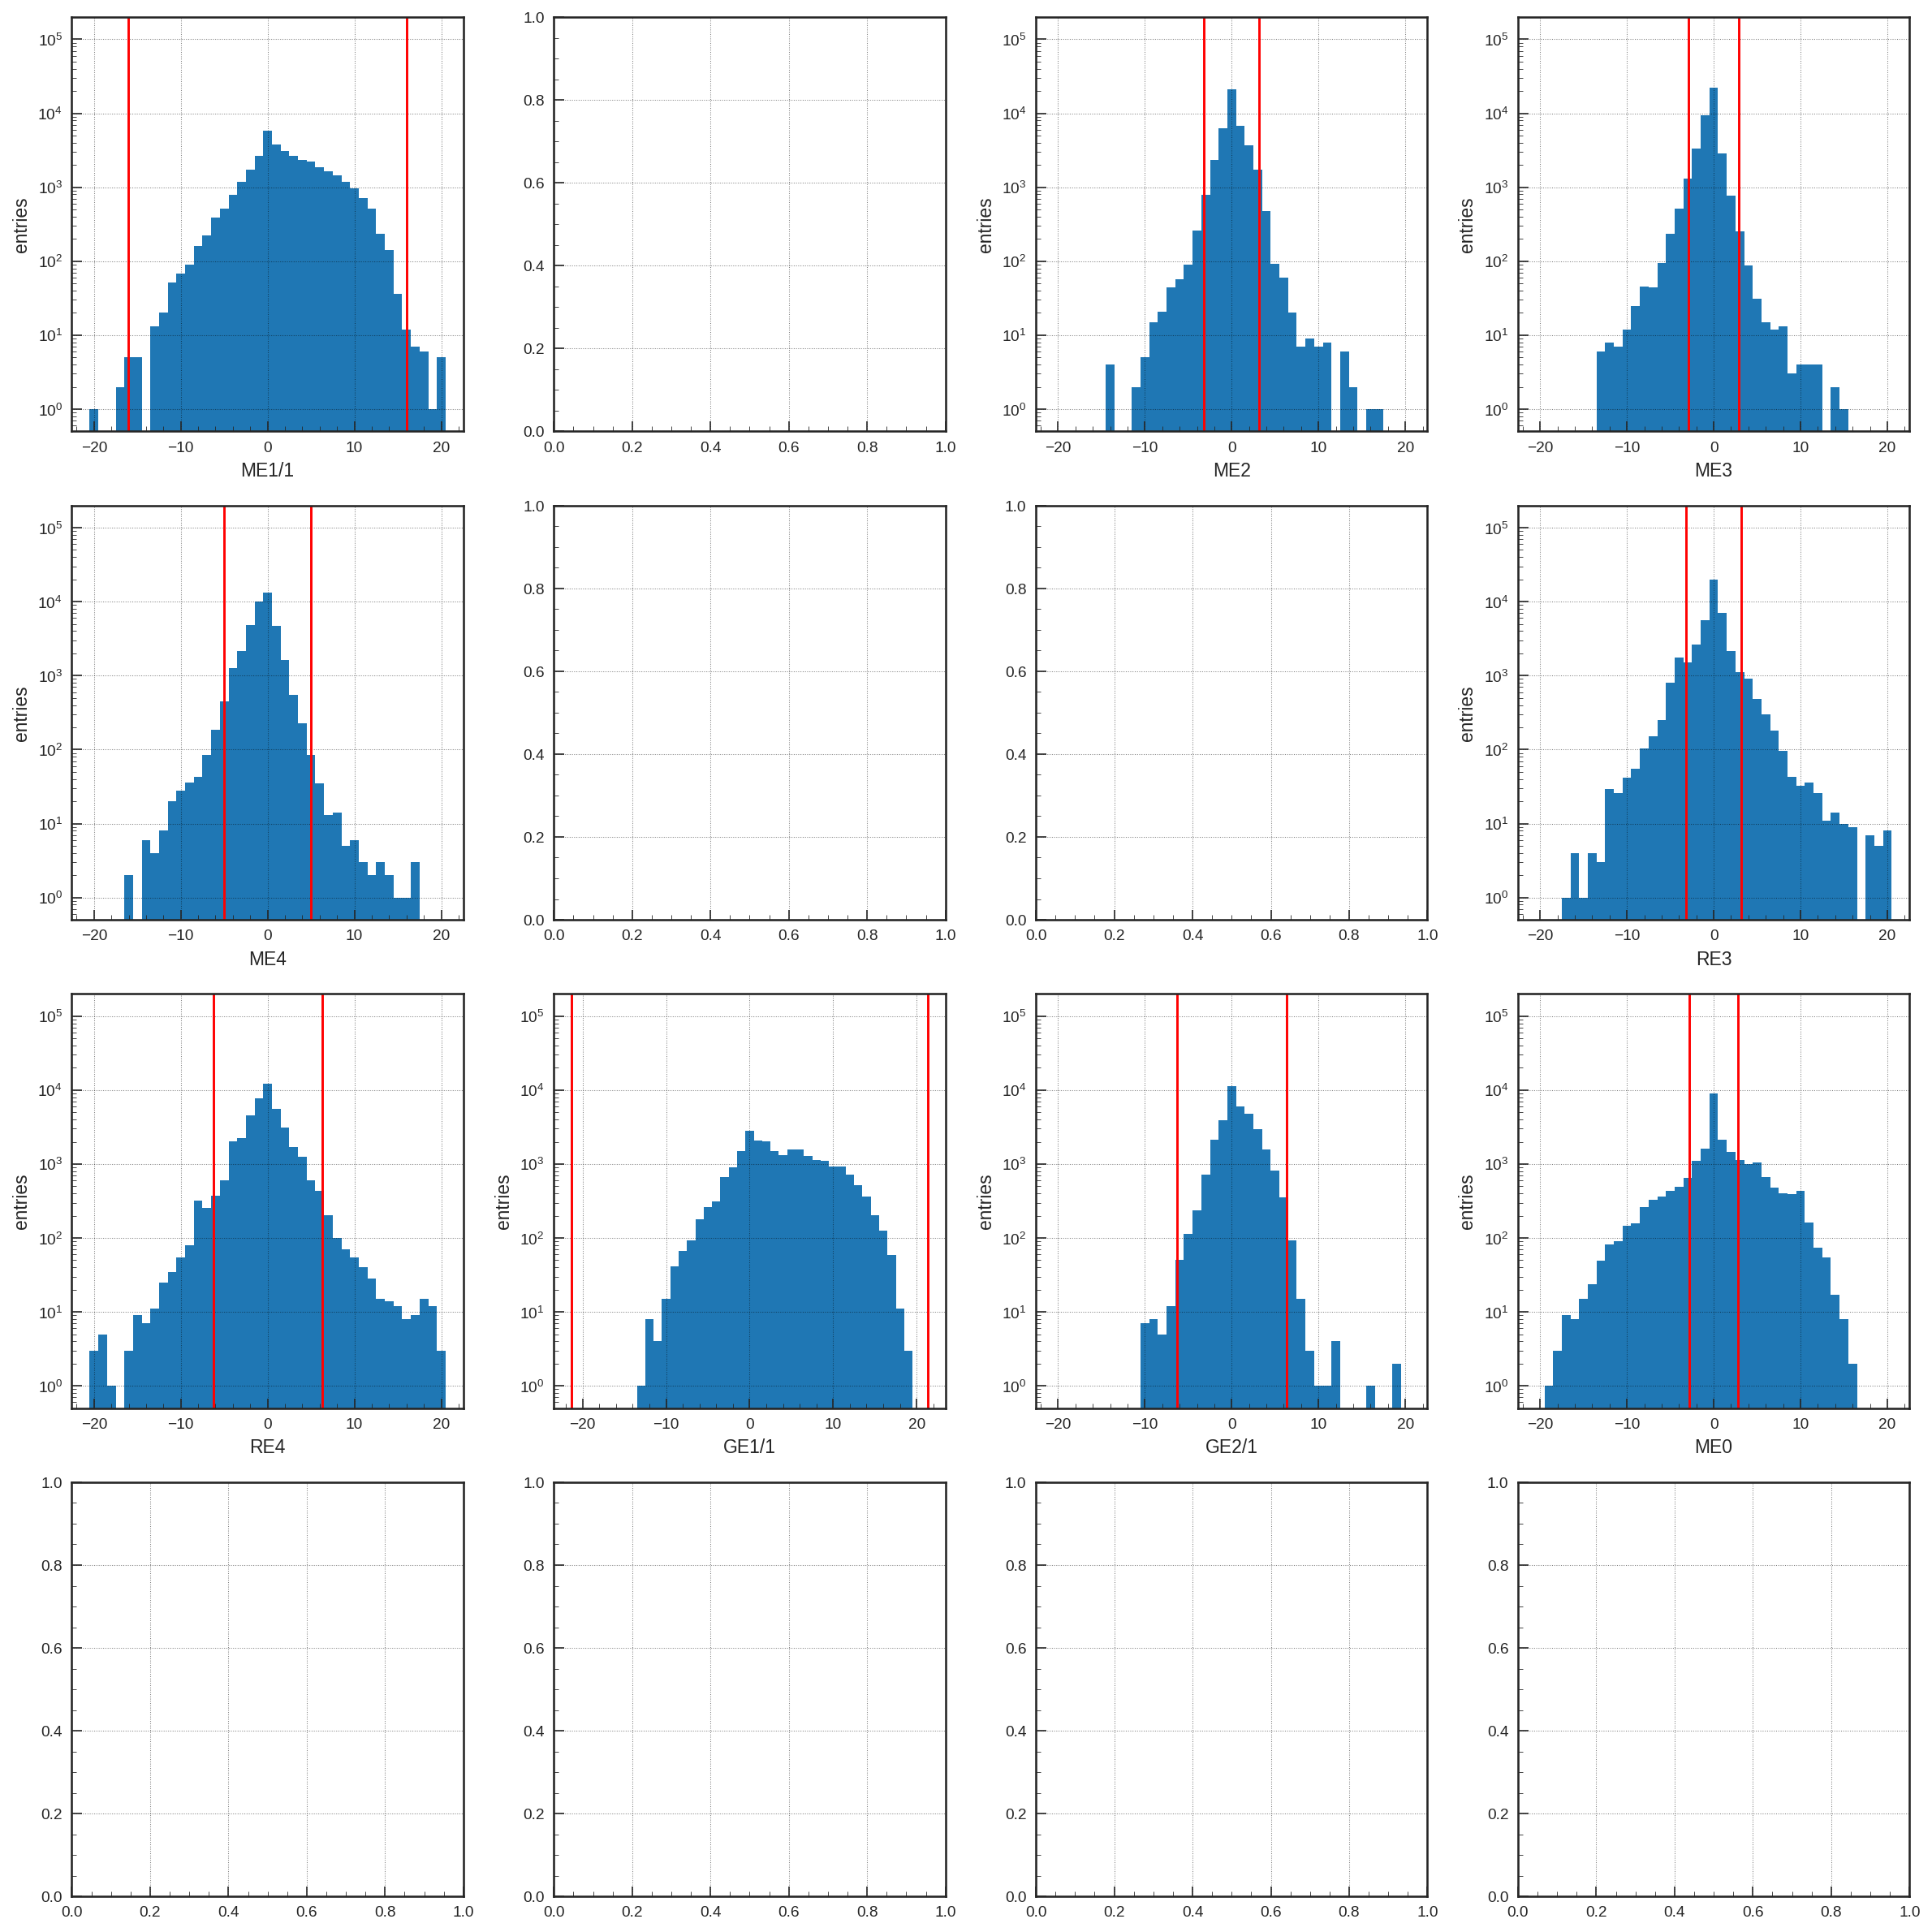

In [11]:
# Plot delta thetas for |eta| > 1.6, pT > 20 GeV
fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)

labels = ['ME1/1', 'ME1/2', 'ME2', 'ME3', 'ME4',
          'RE1', 'RE2', 'RE3', 'RE4',
          'GE1/1', 'GE2/1', 'ME0',
          'MB1', 'MB2', 'MB3', 'MB4']

for i in xrange(nlayers):
  if i == 1:  # skip ME1/2
    continue
  if i == 5 or i == 6:  # skip RE1, RE2
    continue
  if i == 12 or i == 13 or i == 14 or i == 15:  # skip MB1, MB2, MB3, MB4
    continue

  sel = (np.abs(1.0/part_invpt) > 14) & (np.abs(part_eta) > 1.6)
  sel &= (out_hits[:,0]==i)

  data = out_hits[:,1][sel]

  ax = axs[i/4,i%4]
  hist, edges, _ = ax.hist(data, bins=41, range=(-20.5,20.5))
  popt = fit_gaus(hist, edges, mu=0, sig=1)
  print i, 4*popt[2]
  ax.plot([4*popt[2]+0.5, 4*popt[2]+0.5], [0.5, 2e5], color='red')
  ax.plot([-4*popt[2]-0.5, -4*popt[2]-0.5], [0.5, 2e5], color='red')
  ax.set_xlabel(labels[i])
  ax.set_ylabel(r'entries')
  ax.set_yscale('log')
  ax.set_ylim(0.5, 2e5)

plt.show()

1 5.987875484121468
2 2.3832526367878684
3 2.5019346363107657
4 3.600536050241019
5 18.81480076331324
6 14.57201491572269
7 14.56852021320224
8 14.721857617943122


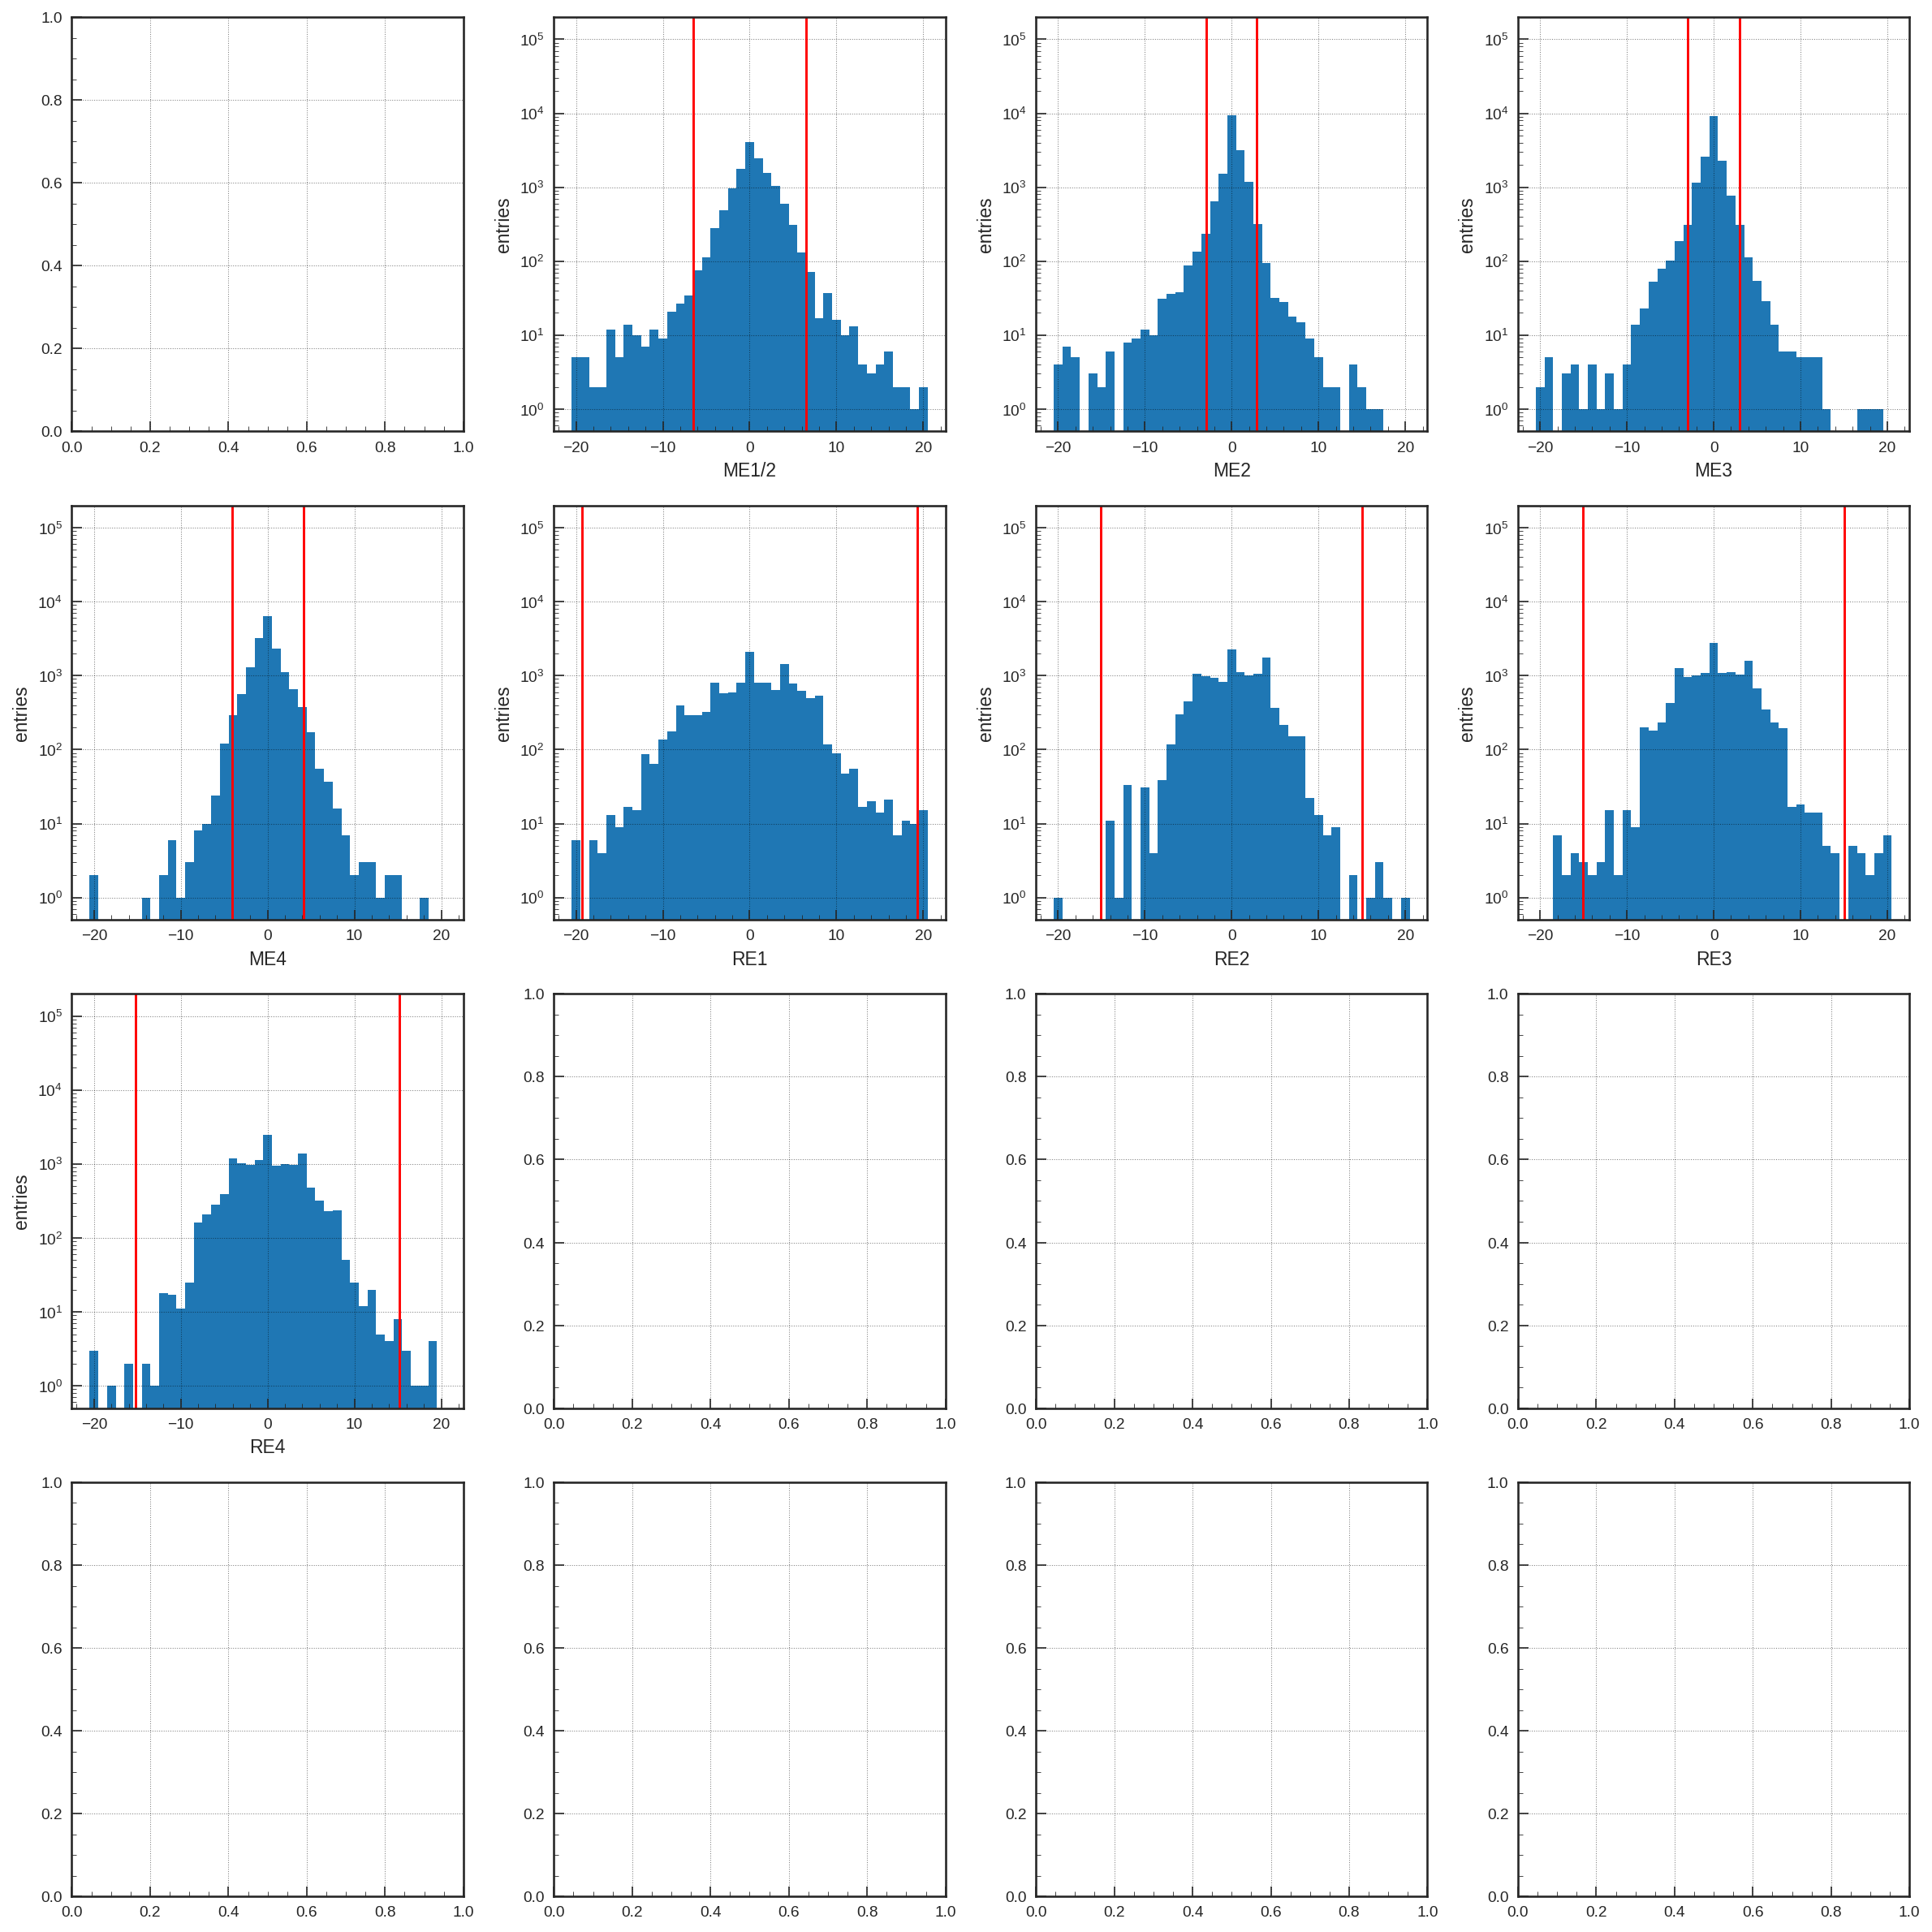

In [12]:
# Plot delta thetas for |eta| < 1.6, pT > 20 GeV
fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)

labels = ['ME1/1', 'ME1/2', 'ME2', 'ME3', 'ME4',
          'RE1', 'RE2', 'RE3', 'RE4',
          'GE1/1', 'GE2/1', 'ME0',
          'MB1', 'MB2', 'MB3', 'MB4']

for i in xrange(nlayers):
  if i == 0:  # skip ME1/1
    continue
  if i == 9 or i == 10 or i == 11:  # skip GE1/1, GE2/1, ME0
    continue
  if i == 12 or i == 13 or i == 14 or i == 15:  # skip MB1, MB2, MB3, MB4
    continue

  sel = (np.abs(1.0/part_invpt) > 14) & (np.abs(part_eta) < 1.6)
  sel &= (out_hits[:,0]==i)

  data = out_hits[:,1][sel]

  ax = axs[i/4,i%4]
  hist, edges, _ = ax.hist(data, bins=41, range=(-20.5,20.5))
  popt = fit_gaus(hist, edges, mu=0, sig=1)
  print i, 4*popt[2]
  ax.plot([4*popt[2]+0.5, 4*popt[2]+0.5], [0.5, 2e5], color='red')
  ax.plot([-4*popt[2]-0.5, -4*popt[2]-0.5], [0.5, 2e5], color='red')
  ax.set_xlabel(labels[i])
  ax.set_ylabel(r'entries')
  ax.set_yscale('log')
  ax.set_ylim(0.5, 2e5)

plt.show()